# Causal Inference

In this notebook, we will use Python package CausalML to estimate Conditional Average Treatment Effect (CATE) for some variables in our data

"Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form."

In his notebook ['INSY_695_Model_Development_Selection_CrossValidation.ipynb'](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/DataScientist/INSY_695_Model_Development_Selection_CrossValidation.ipynb), my teammate Raman Vakil found that an extra tree regressor was the most accurate model for estimating the cost of aquiring a customer, so we will move forward with an extra tree model as our base algorithm in our Meta-Learner algorithm.

### [Business Use Cases to Keep in mind](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/tree/BusinessAnalyst)
**Profit:** the idea here is to look at the ratio (Revenue-Cost)/Revenue, it would be interesting to understand what factors increase or decrease this ratio. If some types of stores are more profitable than others, that also mean the stores in question can reinvest more in their business in the opposite of other that may lose money.


**Loyalty:** We have a loyalty feature based on different categories (normal, bronze, silver, or gold). The idea is to “measure loyalty”.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from causalml.inference.meta import BaseSRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 

## Data

Input data in this notebook is the output of my teammate Chongho Pyo's [preprocessing notebook: ](https://github.com/McGill-MMA-EnterpriseAnalytics/Customer-Aquisition/blob/main/Preprocessing%20(v0.0).ipynb) Data will be modified however with label feature encoding, as opposed to one-hot encoding, this will allow for easier interpretation of treatment variables.

In [4]:
#df_og = pd.read_csv("/Users/bennettfahey/Desktop/Enterprise 1/Group Project/causal_inf_input.csv")
df_og = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/InformationSystem/GroupProject/causal_inf_input.csv")

df = df_og.copy()

### Feature engineering as it relates to our business use cases

In [5]:
df['profit_margin'] = (df['store_sales(in millions)'] - df['store_cost(in millions)']) / df['store_sales(in millions)']
corr_matrix = df.corr()
corr_matrix["cost"].sort_values(ascending=False)

cost                          1.000000
avg_cars_at home(approx)      0.011363
avg_cars_at home(approx).1    0.011363
low_fat                       0.003686
SRP                           0.003002
net_weight                    0.000344
gross_weight                  0.000034
num_children_at_home         -0.001789
recyclable_package           -0.002495
total_children               -0.003141
units_per_case               -0.003508
store_cost(in millions)      -0.005024
profit_margin                -0.005076
store_sales(in millions)     -0.005791
unit_sales(in millions)      -0.019047
grocery_sqft                 -0.026696
store_sqft                   -0.046218
meat_sqft                    -0.059907
frozen_sqft                  -0.059922
coffee_bar                   -0.082083
florist                      -0.112033
salad_bar                    -0.113588
prepared_food                -0.113588
video_store                  -0.123732
Name: cost, dtype: float64

Observed here sales (revenue) is positively correlated with profit margin and cost is negatively correlated.

In [6]:
df

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,avg_cars_at home(approx).1,SRP,gross_weight,net_weight,...,media_type,recyclable_package,low_fat,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,profit_margin
0,-0.388666,-0.464620,0.2,-0.6,-0.5,-0.6,-0.5,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,126.62,-0.195423
1,-0.552878,-0.491556,-0.2,-1.0,1.0,-1.0,1.0,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,59.86,0.110914
2,-0.717091,-0.749375,-0.6,0.6,-0.5,-1.0,-0.5,-0.229885,0.723270,0.650704,...,"Daily Paper, Radio",1.0,0.0,1.0,1.0,1.0,1.0,1.0,84.16,-0.045022
3,-0.717091,-0.787856,-0.6,-0.2,0.0,-0.2,0.0,-0.229885,0.723270,0.650704,...,In-Store Coupon,1.0,0.0,1.0,1.0,1.0,1.0,1.0,95.78,-0.098684
4,-0.560018,-0.499420,0.2,0.6,0.0,-1.0,0.0,-0.505747,-0.859119,-0.767887,...,In-Store Coupon,0.0,1.0,1.0,1.0,1.0,1.0,1.0,95.78,0.108208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57418,-0.799197,-0.757071,-1.0,-0.6,-0.5,-0.6,-0.5,0.298851,0.710692,0.752113,...,In-Store Coupon,1.0,0.0,1.0,0.0,0.0,0.0,0.0,95.25,0.052710
57419,-0.902722,-0.930401,-1.0,-0.2,0.0,-1.0,0.0,-0.367816,0.433962,0.380282,...,Sunday Paper,1.0,0.0,1.0,0.0,0.0,0.0,0.0,69.42,-0.030661
57420,-0.552878,-0.503100,-0.6,-0.6,0.5,-1.0,0.5,0.298851,0.710692,0.752113,...,"Sunday Paper, Radio, TV",1.0,0.0,1.0,0.0,0.0,0.0,0.0,67.51,0.090034
57421,-0.306560,-0.497328,-0.2,-0.2,1.0,-1.0,1.0,0.298851,0.710692,0.752113,...,Sunday Paper,1.0,0.0,1.0,0.0,0.0,0.0,1.0,132.88,-0.622289


In [7]:
#Ordinal encode Member_Card

mapping = {'Normal': 0, 'Bronze': 1, 'Silver': 2, 'Golden': 3}

df['member_card'] = df['member_card'].map(mapping)


#One-Hot Encode Media_type
one_hot = pd.get_dummies(df['media_type'])

df = pd.concat([df, one_hot], axis=1)



#Label encode the rest of categorical

label_encoder = preprocessing.LabelEncoder() 

for column in df.columns:
    if df[column].dtype == 'object': 
        df[column] = label_encoder.fit_transform(df[column].tolist()) 
        


# UC1: Effect of Gender on Cost of aquisition

In [8]:
#Gender on cost
#Something on ratio
#loyalty

df2 = df.copy()
y = df2["cost"]
W = df2[["gender"]]
W = np.array(W)
X = df2.drop(columns = ["cost"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [9]:
features = X.columns
features

Index(['store_sales(in millions)', 'store_cost(in millions)',
       'unit_sales(in millions)', 'total_children', 'avg_cars_at home(approx)',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'SRP',
       'gross_weight', 'net_weight', 'units_per_case', 'store_sqft',
       'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'food_category',
       'food_department', 'food_family', 'promotion_name', 'sales_country',
       'marital_status', 'gender', 'education', 'member_card', 'occupation',
       'houseowner', 'avg. yearly_income', 'brand_name', 'store_type',
       'store_city', 'store_state', 'media_type', 'recyclable_package',
       'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'profit_margin', 'Bulk Mail', 'Cash Register Handout',
       'Daily Paper', 'Daily Paper, Radio', 'Daily Paper, Radio, TV',
       'In-Store Coupon', 'Product Attachment', 'Radio', 'Street Handout',
       'Sunday Paper', 'Sunday Paper, Radio', 'Sunday Paper, R

In [10]:
base_algo = ExtraTreesRegressor()

In [11]:
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.152578
 occupation                    0.065027
 gender                        0.061862
 total_children                0.059415
 avg. yearly_income            0.057006
 education                     0.049766
 store_city                    0.045224
 houseowner                    0.039627
 avg_cars_at home(approx).1    0.037670
 avg_cars_at home(approx)      0.035492
 member_card                   0.033383
 marital_status                0.030366
 num_children_at_home          0.030244
 frozen_sqft                   0.026063
 store_state                   0.023488
 grocery_sqft                  0.023297
 meat_sqft                     0.023089
 unit_sales(in millions)       0.021513
 store_sqft                    0.021416
 Cash Register Handout         0.020099
 coffee_bar                    0.017735
 Daily Paper                   0.016833
 florist                       0.011061
 store_type                    0.010232
 prepared_food           

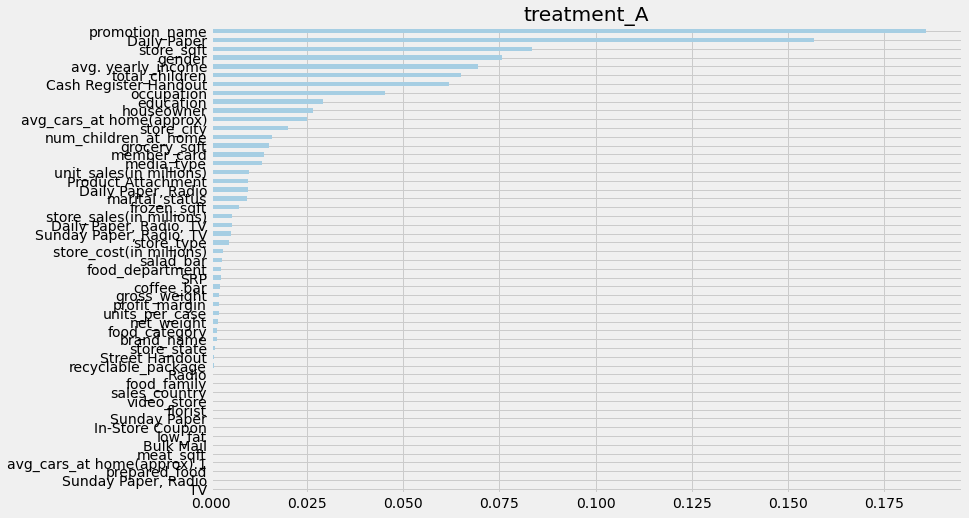

In [12]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

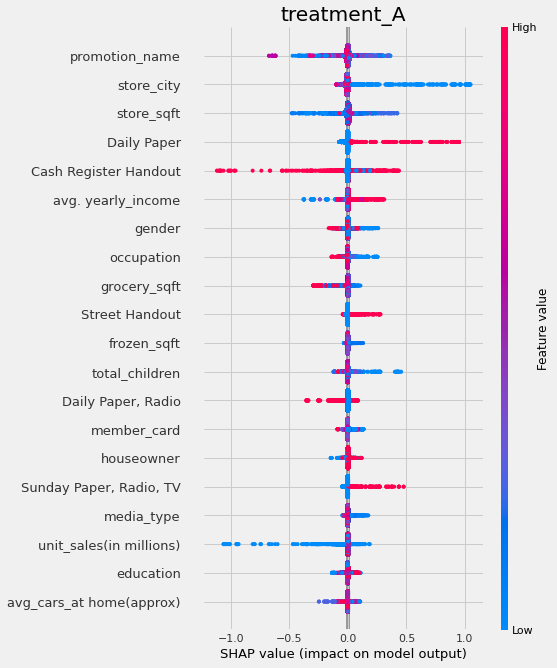

In [13]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)


# UC2: Member card (ordinal encoded) status on cost

In [14]:
df2 = df.copy()
y = df2["cost"]
W = df2[["member_card"]]
W = np.array(W)
X = df2.drop(columns = [ "cost"])

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [15]:
base_algo = ExtraTreesRegressor()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.191515
 education                     0.069620
 occupation                    0.066156
 total_children                0.059778
 avg. yearly_income            0.056000
 member_card                   0.054523
 avg_cars_at home(approx)      0.051229
 avg_cars_at home(approx).1    0.050206
 houseowner                    0.037623
 num_children_at_home          0.036767
 gender                        0.032163
 marital_status                0.031001
 Product Attachment            0.017543
 frozen_sqft                   0.014576
 Daily Paper, Radio            0.014356
 meat_sqft                     0.013835
 store_state                   0.013169
 store_sqft                    0.012514
 store_city                    0.011633
 Daily Paper                   0.011231
 grocery_sqft                  0.010501
 video_store                   0.009781
 coffee_bar                    0.008720
 food_department               0.007178
 store_type              

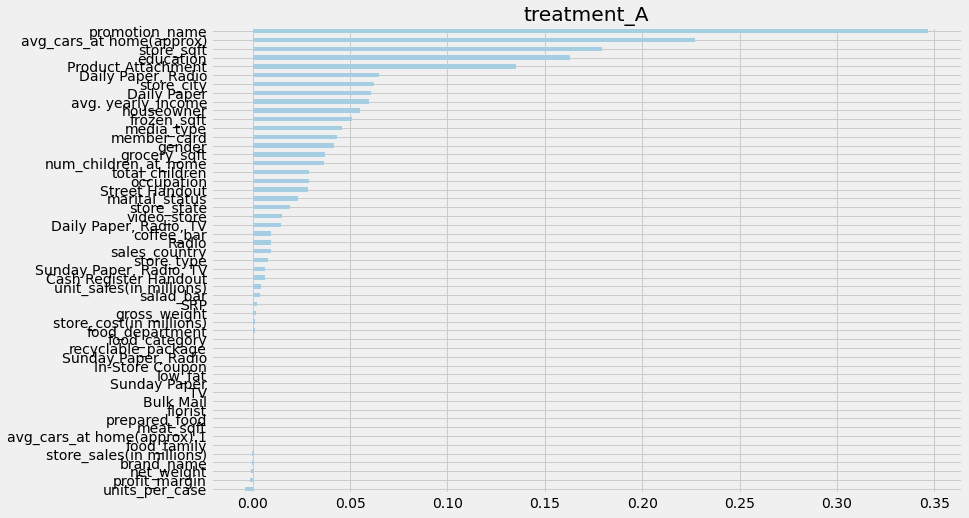

In [16]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='permutation', #auto
                         features=features)

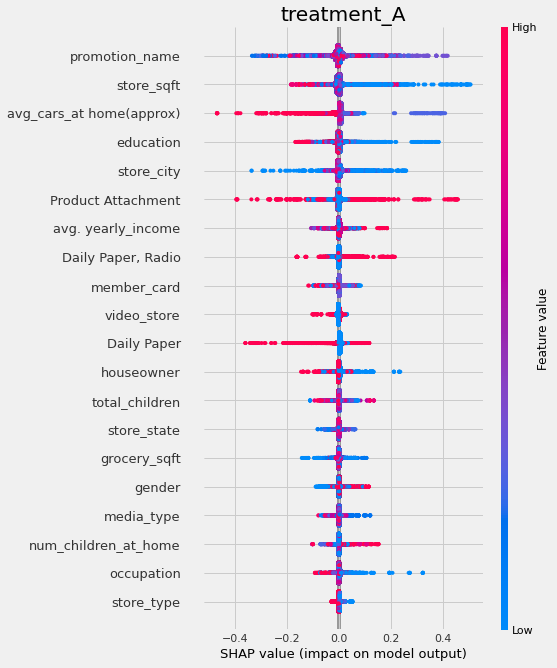

In [17]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)

# UC3: Media type (one-hot encoded) effect on cost

In [18]:
y = df2["cost"]
W = df2[["media_type"]]
W = np.array(W)
X = df2.drop(columns = ["cost"]) #dummify

w_multi = np.empty(W.shape[0], dtype=object)
for i, value in enumerate(W):
    if value == 1:
        w_multi[i] = 'treatment_A'
    else:
        w_multi[i] = 'control'


In [19]:
base_algo = ExtraTreesRegressor()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
model_tau_feature = base_algo  # specify model for model_tau_feature
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='auto', features=features)

{'treatment_A': promotion_name                0.228590
 video_store                   0.059959
 store_state                   0.059206
 store_sqft                    0.058041
 Radio                         0.045002
 store_type                    0.039542
 frozen_sqft                   0.038490
 store_city                    0.038369
 Street Handout                0.037854
 meat_sqft                     0.036338
 sales_country                 0.034601
 media_type                    0.033175
 grocery_sqft                  0.031477
 Sunday Paper, Radio, TV       0.029480
 Daily Paper, Radio            0.028051
 Daily Paper, Radio, TV        0.023927
 Sunday Paper, Radio           0.021388
 Sunday Paper                  0.020709
 salad_bar                     0.017667
 In-Store Coupon               0.017060
 Product Attachment            0.016737
 TV                            0.016710
 Daily Paper                   0.014984
 Bulk Mail                     0.014348
 prepared_food           

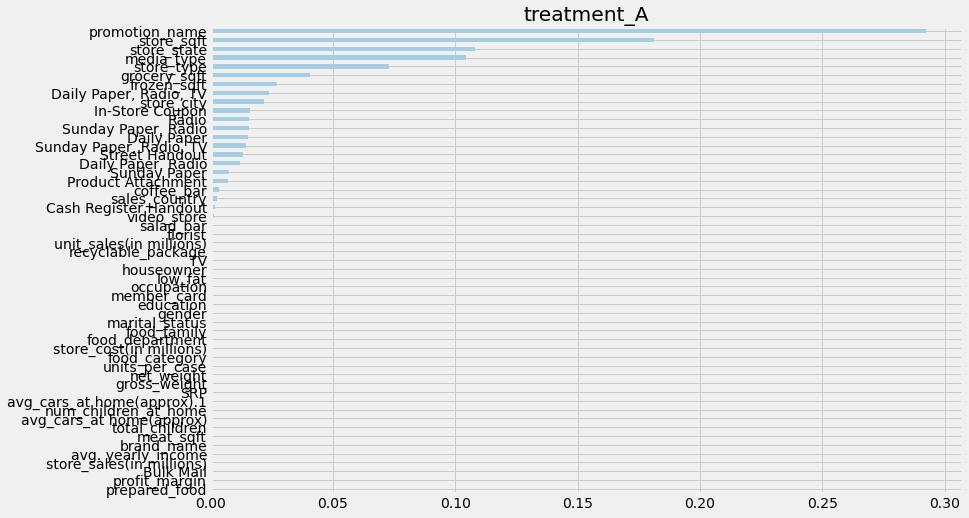

In [20]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=features)

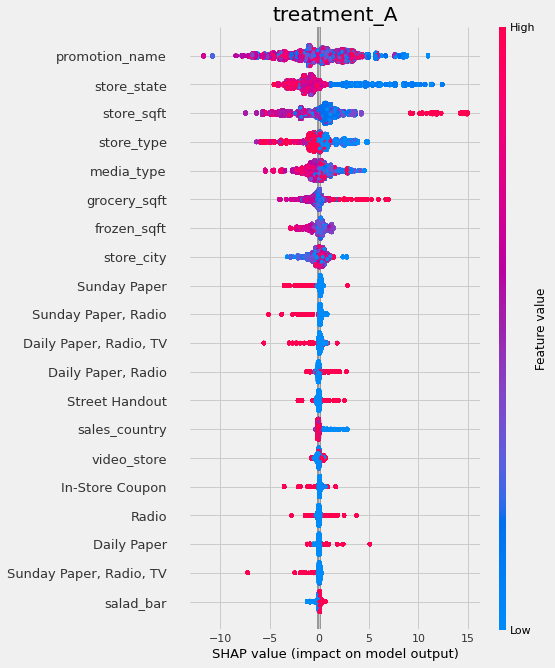

In [21]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features = features)